# Pedestrians skeletons missing joints recovering using targeted denoising autoencoder

Recovery of missing joints in skeletons using a denoising autoencoder. The notebook also shows the 2 types of denoising that can be used with my classes: random denoising that has an equal probability of adding noise to each node, or my targeted denoising approach that in this case adds noise more likely to node 8 (the neck) and nearby nodes, since it is the most crucial node when it comes to classifying between crossing and not-crossing, at least in CARLA.

My targeted denoising allows to retrieve skeletons that give better classification results than random denoising.

In [ ]:
import numpy as np

from torch import from_numpy
from torch import cuda
from torch import no_grad
from torch import optim

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

import matplotlib.pyplot as plt

import pandas as pd

%matplotlib inline

from Code.Autoencoder import *
from Code.SkeletonsDataset import *
from Code.ModelTrainEvaluate import *
from Code.MetricsPlots import *

In [2]:
info = 3

train_dataset = SkeletonsDataset('Data/CARLA/train_preprocessed.csv', numberOfJoints=26,
                                 normalization='minmax', target='crossing', info=info, remove_undetected=False)

In [3]:
print('train_dataset len:', len(train_dataset))
print('Temporal dimension length:', len(train_dataset.data[0].x_temporal))
print('Shape of each skeletons data (x):', train_dataset.data[0].x_temporal[0].shape)

train_dataset.loadedData

train_dataset len: 151291
Temporal dimension length: 3
Shape of each skeletons data (x): torch.Size([26, 3])


,Unnamed: 0,Unnamed: 0.1,id,video,frame,skeleton,crossing
0,274800,274800,d1d1c0e1-550a-44ae-9ada-e6b16e52ba48,clips/57-7-0-0.mp4,0,"[[-2805.490966796875, -93.4703369140625, 0], [...",0
1,274801,274801,d1d1c0e1-550a-44ae-9ada-e6b16e52ba48,clips/57-7-0-0.mp4,1,"[[-2785.79541015625, -79.54444122314453, 0], [...",0
2,274802,274802,d1d1c0e1-550a-44ae-9ada-e6b16e52ba48,clips/57-7-0-0.mp4,2,"[[-2765.295654296875, -65.11300659179688, 0], ...",0
3,274803,274803,d1d1c0e1-550a-44ae-9ada-e6b16e52ba48,clips/57-7-0-0.mp4,3,"[[-2744.0283203125, -50.199893951416016, 0], [...",0
4,274804,274804,d1d1c0e1-550a-44ae-9ada-e6b16e52ba48,clips/57-7-0-0.mp4,4,"[[-2722.03759765625, -34.829925537109375, 0], ...",0
...,...,...,...,...,...,...,...
151795,219595,219595,d37bcb41-11ce-4696-b6c9-3c663a44119a,clips/47-11-0-0.mp4,595,"[[-159.25418090820312, 2856.2373046875, 0], [-...",0
151796,219596,219596,d37bcb41-11ce-4696-b6c9-3c663a44119a,clips/47-11-0-0.mp4,596,"[[-158.1601104736328, 2856.507568359375, 0], [...",0
151797,219597,219597,d37bcb41-11ce-4696-b6c9-3c663a44119a,clips/47-11-0-0.mp4,597,"[[-157.06983947753906, 2856.77734375, 0], [-15...",0
151798,219598,219598,d37bcb41-11ce-4696-b6c9-3c663a44119a,clips/47-11-0-0.mp4,598,"[[-155.98318481445312, 2857.046142578125, 0], ...",0


In [4]:
val_dataset = SkeletonsDataset('Data/CARLA/val_preprocessed.csv', numberOfJoints=26,
                               normalization='minmax', target='crossing', info=info, remove_undetected=False)

In [5]:
test_dataset = SkeletonsDataset('Data/CARLA/test_preprocessed.csv', numberOfJoints=26,
                               normalization='minmax', target='crossing', info=info, remove_undetected=False)

In [6]:
def train(model, train_loader, device, optimizer, crit):

    model.train()

    loss_all = 0
    samples = 0

    for data in train_loader:

        data = data.to(device)
        optimizer.zero_grad()

        output = model(data, noise='random')

        label = data.x_temporal[0].to(device)
        
        label = reshape(label, (output.shape[0], output.shape[1]))
        
        loss = crit(output, label)

        loss.backward()
        loss_all = loss_all + loss.item()
        samples = samples + 1
        optimizer.step()

    return loss_all / samples

In [7]:
num_epochs = 25
batch_size = 1500

device = torch.device('cpu')
#model = GraphConvolutionalAutoencoder(3, 26).to(device)
model = FC_Autoencoder(3, 26).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
crit = torch.nn.MSELoss()

train_loader = DataLoader(train_dataset[0:], batch_size=batch_size)
val_loader = DataLoader(val_dataset[0:], batch_size=batch_size)

loss_values_train = []
loss_values_val = []

metrics_train = []
metrics_val = []

for epoch in range(num_epochs):

    train_loss = train(model, train_loader, device, optimizer, crit)
    loss_values_train.append(train_loss)
    
    val_loss = 0
    val_samples = 0
    
    with no_grad():
        for data in val_loader:
            
            data = data.to(device)
            
            output = model(data, noise='random').detach()
            
            label = data.x_temporal[0].to(device)
            
            label = reshape(label, (output.shape[0], output.shape[1]))
        
            loss = crit(output, label)

            val_loss = val_loss + loss.item() # * data.num_graphs
            val_samples = val_samples + 1
            
    val_loss = val_loss / val_samples
    loss_values_val.append(val_loss)
    
    if (num_epochs <= 25) or (epoch % 10 == 0):
        print('Epoch ', epoch+1, '- Train MSE loss:', round(train_loss, 4), '- Val MSE loss:', round(val_loss, 3))

Epoch  1 - Train MSE loss: 0.1141 - Val MSE loss: 0.1
Epoch  2 - Train MSE loss: 0.072 - Val MSE loss: 0.062
Epoch  3 - Train MSE loss: 0.0612 - Val MSE loss: 0.062
Epoch  4 - Train MSE loss: 0.0606 - Val MSE loss: 0.061
Epoch  5 - Train MSE loss: 0.0614 - Val MSE loss: 0.061
Epoch  6 - Train MSE loss: 0.0621 - Val MSE loss: 0.063
Epoch  7 - Train MSE loss: 0.0599 - Val MSE loss: 0.059
Epoch  8 - Train MSE loss: 0.059 - Val MSE loss: 0.057
Epoch  9 - Train MSE loss: 0.057 - Val MSE loss: 0.053
Epoch  10 - Train MSE loss: 0.0525 - Val MSE loss: 0.049
Epoch  11 - Train MSE loss: 0.0491 - Val MSE loss: 0.048
Epoch  12 - Train MSE loss: 0.0477 - Val MSE loss: 0.045
Epoch  13 - Train MSE loss: 0.0453 - Val MSE loss: 0.044
Epoch  14 - Train MSE loss: 0.0446 - Val MSE loss: 0.044
Epoch  15 - Train MSE loss: 0.0447 - Val MSE loss: 0.043
Epoch  16 - Train MSE loss: 0.0452 - Val MSE loss: 0.043
Epoch  17 - Train MSE loss: 0.0416 - Val MSE loss: 0.041
Epoch  18 - Train MSE loss: 0.0381 - Val MSE 

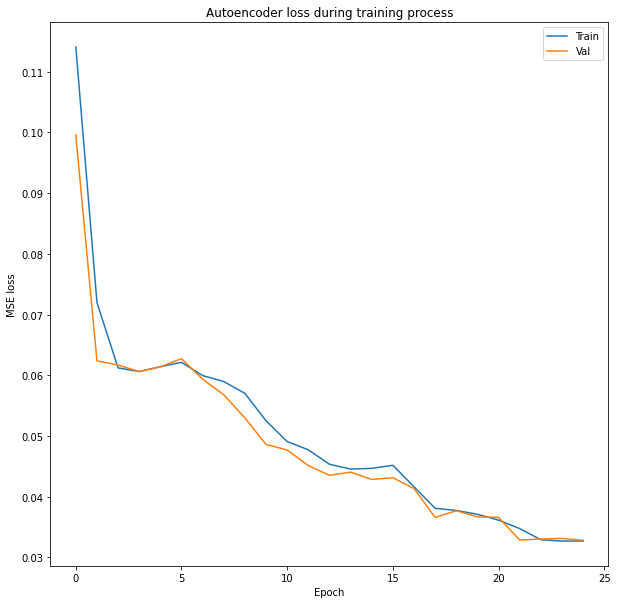

In [8]:
plt.figure(figsize=(10,10))
plt.title('Autoencoder loss during training process')
plt.plot(np.arange(0, len(loss_values_train)), loss_values_train, label='Train')
plt.plot(np.arange(0, len(loss_values_val)), loss_values_val, label='Val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.show()

# Denoising explanation

I performed denoising setting to zero the coordinates of the different joints to make them be missing like happens when using OpenPose on JAAD, for example.

To make them missing, I first used a random denoising strategy using a uniform distribution:

In [9]:
# This are the nodes that if missing, the results of the crossing/not-crossing classification are almost random (0.5 balanced accuracy aprox.)
n = train_dataset.body_parts['crl_neck__C']
sl = train_dataset.body_parts['crl_shoulder__L']
sr = train_dataset.body_parts['crl_shoulder__R']

print(n, sl, sr)

x = train_dataset[0].x_temporal[0]

8 4 12


# Random denoising:

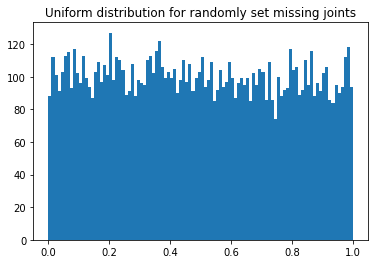

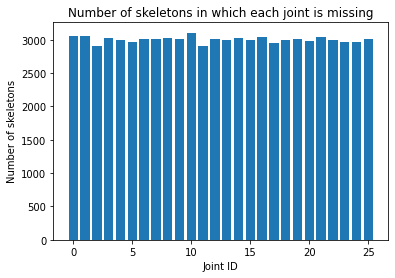

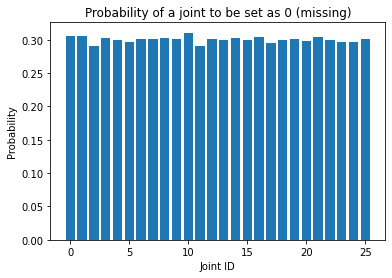

In [10]:
v = np.random.uniform(size=(10000))

plt.figure()
plt.title('Uniform distribution for randomly set missing joints')
plt.hist(v, 100)
plt.show()

vi = 10000 - np.sum(np.where(np.random.uniform(size=(x.shape[0], 10000)) <= 0.3, 0, 1), axis=1)

plt.figure()
plt.title('Number of skeletons in which each joint is missing')
plt.xlabel('Joint ID')
plt.ylabel('Number of skeletons')
plt.bar(range(0, vi.shape[0]), vi)
plt.show()

vi_p = vi / 10000

plt.figure()
plt.title('Probability of a joint to be set as 0 (missing)')
plt.xlabel('Joint ID')
plt.ylabel('Probability')
plt.bar(range(0, vi_p.shape[0]), vi_p)
plt.show()

## Targeted denoising:

Now I use a normal distribution with mean 8 because 8 is the ID of the neck, the most important joint (if missing the results are awful). In this way, as you can see in the plots below, the neck now has a higher probability of being set to 0 (force it to be missing during autoencoder training):

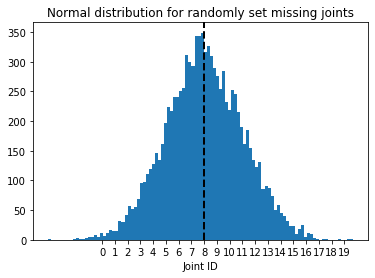

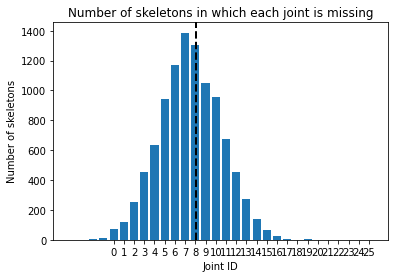

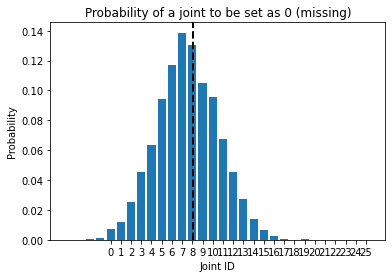

In [11]:
v = np.random.normal(loc=8, scale=3, size=10000)

vi_unique_values, vi_counts = np.unique(v.astype(int), return_counts=True)

plt.figure()
plt.title('Normal distribution for randomly set missing joints')
plt.xlabel('Joint ID')
plt.hist(v, 100)
plt.xticks(np.arange(0, np.max(vi_unique_values) + 1))
plt.axvline(v.mean(), color='k', linestyle='dashed', linewidth=2)
plt.show()

# Add the joints that were not added randomly with the normal distribution:
for i in range(0, 26):
    if i not in vi_unique_values:
        vi_unique_values = np.append(vi_unique_values, i)
        vi_counts = np.append(vi_counts, 0)

plt.figure()
plt.title('Number of skeletons in which each joint is missing')
plt.xlabel('Joint ID')
plt.ylabel('Number of skeletons')
plt.bar(vi_unique_values, vi_counts)
plt.xticks(np.arange(0, np.max(vi_unique_values) + 1))
plt.axvline(v.mean(), color='k', linestyle='dashed', linewidth=2)
plt.show()

vi_counts_p = vi_counts / 10000

plt.figure()
plt.title('Probability of a joint to be set as 0 (missing)')
plt.xlabel('Joint ID')
plt.ylabel('Probability')
plt.bar(vi_unique_values, vi_counts_p)
plt.xticks(np.arange(0, np.max(vi_unique_values) + 1))
plt.axvline(v.mean(), color='k', linestyle='dashed', linewidth=2)
plt.show()

In [43]:
def targeted_denoising(threshold=0.3):
    v = np.random.normal(loc=8, scale=3, size=10000)
    vi_unique_values, vi_counts = np.unique(v.astype(int), return_counts=True)
    
    for i in range(0, 26):
        if i not in vi_unique_values:
            vi_unique_values = np.append(vi_unique_values, i)
            vi_counts = np.append(vi_counts, 0)
            
    sorted_index = np.argsort(vi_unique_values)
    vi_unique_values = vi_unique_values[sorted_index]
    vi_counts = vi_counts[sorted_index]
    
    if np.min(vi_unique_values) < 0:
        zero_pos = np.argwhere(vi_unique_values == 0)[0][0]
        vi_unique_values = vi_unique_values[zero_pos:]
        vi_counts = vi_counts[zero_pos:]
        
    if vi_unique_values.shape[0] > 26:
        vi_unique_values = vi_unique_values[0:26]
        vi_counts = vi_counts[0:26]
                
    vi_counts_p = vi_counts / 10000
    
    n_th = vi_counts_p.reshape(-1, 1) + threshold
        
    return np.where(np.random.uniform(size=(vi_counts_p.shape[0], 1)) <= n_th, 0, 1)

#### Extra threshold of 0.0:

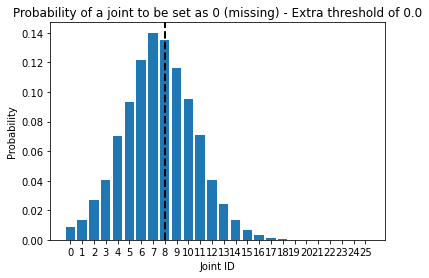

In [44]:
missings = []

for i in range(0, 10000):
    vt = targeted_denoising(threshold=0)
    
    if missings is None:
        missings = vt
    else:
        missings.append(vt.reshape(-1))
    
missings = np.asarray(missings)
#missings = missings.reshape(26, 1000)

vi = (10000 - np.sum(missings, axis=0)) / 10000

plt.figure()
plt.title('Probability of a joint to be set as 0 (missing) - Extra threshold of 0.0')
plt.xlabel('Joint ID')
plt.ylabel('Probability')
plt.bar(np.arange(vi.shape[0]), vi.reshape(-1))
plt.xticks(np.arange(0, 26))
plt.axvline(v.mean(), color='k', linestyle='dashed', linewidth=2)
plt.show()

#### Extra threshold of 0.15:

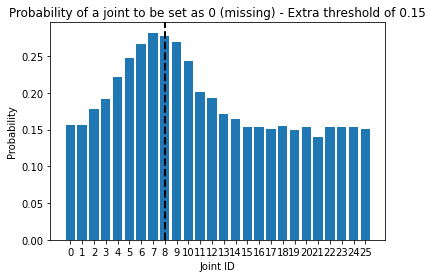

In [45]:
missings = []

for i in range(0, 10000):
    vt = targeted_denoising(threshold=0.15)
    
    if missings is None:
        missings = vt
    else:
        missings.append(vt.reshape(-1))
    
missings = np.asarray(missings)
#missings = missings.reshape(26, 1000)

vi = (10000 - np.sum(missings, axis=0)) / 10000

plt.figure()
plt.title('Probability of a joint to be set as 0 (missing) - Extra threshold of 0.15')
plt.xlabel('Joint ID')
plt.ylabel('Probability')
plt.bar(np.arange(vi.shape[0]), vi.reshape(-1))
plt.xticks(np.arange(0, 26))
plt.axvline(v.mean(), color='k', linestyle='dashed', linewidth=2)
plt.show()

#### Extra threshold of 0.3:

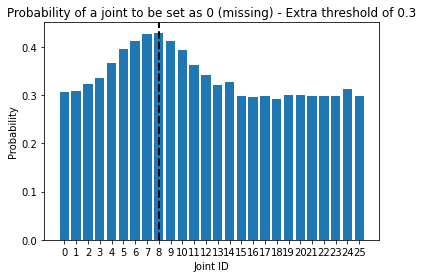

In [46]:
missings = []

for i in range(0, 10000):
    vt = targeted_denoising(threshold=0.3)
    
    if missings is None:
        missings = vt
    else:
        missings.append(vt.reshape(-1))
    
missings = np.asarray(missings)
#missings = missings.reshape(26, 1000)

vi = (10000 - np.sum(missings, axis=0)) / 10000

plt.figure()
plt.title('Probability of a joint to be set as 0 (missing) - Extra threshold of 0.3')
plt.xlabel('Joint ID')
plt.ylabel('Probability')
plt.bar(np.arange(vi.shape[0]), vi.reshape(-1))
plt.xticks(np.arange(0, 26))
plt.axvline(v.mean(), color='k', linestyle='dashed', linewidth=2)
plt.show()

# Generate new dataset with predicted skeletons

In [57]:
predicted_dataset = []

for i, x_i in enumerate(train_dataset[0:91800]):
    
    x_temporal = []
    
    for x_j in x_i.x_temporal:
                
        pred_i = x_j.clone().detach().numpy()
        
        pred_i = pred_i * np.repeat(np.where(np.random.uniform(size=(pred_i.shape[0], 1)) <= 0.3, 0, 1), 3, axis=1) # Force missing joints
        
        pred_i = torch.Tensor(pred_i)
        
        data_i = Data(x_temporal=[pred_i], y=x_i.y, label=x_i.label, edge_index=x_i.edge_index, num_nodes=x_i.num_nodes, edge_weight=x_i.edge_weight, videoID=x_i.videoID)
        pred_i = model(data_i, noise=False).detach().numpy()
    
        pred_i = pred_i.reshape(26, 3)

        pred_i = torch.tensor(pred_i, dtype=torch.float)
        
        x_temporal.append(pred_i)
    
    
    data_element = Data(x_temporal=x_temporal, y=x_i.y, label=x_i.label, edge_index=x_i.edge_index,
                        num_nodes=x_i.num_nodes, edge_weight=x_i.edge_weight, videoID=x_i.videoID)

    predicted_dataset.append(data_element)

In [58]:
gnn_loader = DataLoader(predicted_dataset, batch_size=500)

# Loading the GNN classifier model

In [59]:
from Code.GNN import *

GNN_model = SpatialTemporalGNN(3, 2, 26)

model_path = 'Missing joints stats/exportedModels/CARLA/Approach_2-3_joint_Any' #'exportedModels/CARLA/Approach_2-3'
GNN_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [60]:
# evaluate(GNN_model, DataLoader(train_dataset[0:91800], batch_size=500), device) # Original CARLA dataset without modifications

In [61]:
evaluate(GNN_model, gnn_loader, device)

{'Accuracy': 0.6307407407407407,
 'Balanced accuracy': 0.6011564009661836,
 'Precision': 0.6107338415288812,
 'Recall': 0.9029166666666667,
 'f1-score': 0.7286249519661842}